**Étape 1 : Importation des librairies et Chargement**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib # Pour sauvegarder le modèle

# Configuration pour l'affichage
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Charger les données (Assurez-vous que le fichier s'appelle 'morocco.csv')
# On essaye de parser les dates directement, sinon on le fera au nettoyage
try:
    df = pd.read_csv('morocco.csv')
    print("Données chargées avec succès.")
except FileNotFoundError:
    print("Erreur : Le fichier 'morocco.csv' est introuvable.")

Données chargées avec succès.


**Étape 2 : Nettoyage Profond des Données**

In [2]:
def clean_data(data):
    df_clean = data.copy()

    # 1. Nettoyer les noms de colonnes (enlever les espaces avant/après)
    df_clean.columns = df_clean.columns.str.strip()
    
    # 2. Conversion de la colonne DateTime
    # Le format semble être jour-mois-année heure:minute
    # On utilise format='mixed' pour gérer les différences (tiret vs slash)
    # On ajoute dayfirst=True car au Maroc, le format est généralement Jour/Mois/Année.
    # Si cela échoue encore, enlevez 'dayfirst=True'.
    df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'], format='mixed', dayfirst=True)
    # 3. Création de la variable cible (Target)
    # L'utilisateur veut détecter "l'énergie consommée". 
    # Souvent, c'est la somme des 3 zones. Si vous voulez prédire une seule zone, modifiez ici.
    df_clean['Total_Consumption'] = df_clean['Zone 1'] + df_clean['Zone 2'] + df_clean['Zone 3']

    # 4. Feature Engineering (Ingénierie des fonctionnalités)
    # Le XGBoost ne comprend pas "DateTime". Il faut extraire les cycles.
    df_clean['Hour'] = df_clean['DateTime'].dt.hour
    df_clean['Month'] = df_clean['DateTime'].dt.month
    df_clean['DayOfWeek'] = df_clean['DateTime'].dt.dayofweek
    df_clean['DayOfMonth'] = df_clean['DateTime'].dt.day
    df_clean['Year'] = df_clean['DateTime'].dt.year # Moins pertinent si on prédit le futur sans cette année, mais utile pour le train
    
    # 5. Gestion des valeurs numériques
    # S'assurer que tout est bien en float
    cols_to_numeric = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']
    for col in cols_to_numeric:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # 6. Gestion des valeurs manquantes (NaN)
    # On remplit par la moyenne ou interpolation (car c'est une série temporelle)
    df_clean.fillna(df_clean.mean(), inplace=True)
    # 7. Suppression des colonnes inutiles pour l'entraînement
    # On enlève DateTime (car on a extrait les infos) et les Zones individuelles (car on prédit le total)
    drop_cols = ['DateTime', 'Zone 1', 'Zone 2', 'Zone 3']
    df_clean = df_clean.drop(columns=drop_cols)

    return df_clean

# Appliquer le nettoyage
df_processed = clean_data(df)

# Vérification
print("Aperçu des données nettoyées pour le modèle :")
print(df_processed.head())
print("\nTypes des données :")
print(df_processed.dtypes)

Aperçu des données nettoyées pour le modèle :
   Temperature  Humidity  Wind Speed  general diffuse flows  diffuse flows  \
0        6.559      73.8       0.083                  0.051          0.119   
1        6.414      74.5       0.083                  0.070          0.085   
2        6.313      74.5       0.080                  0.062          0.100   
3        6.121      75.0       0.083                  0.091          0.096   
4        5.921      75.7       0.081                  0.048          0.085   

   Total_Consumption  Hour  Month  DayOfWeek  DayOfMonth  Year  
0        70425.53544     0      1          6           1  2017  
1        69320.84387     0      1          6           1  2017  
2        67803.22193     0      1          6           1  2017  
3        65489.23209     0      1          6           1  2017  
4        63650.44627     0      1          6           1  2017  

Types des données :
Temperature              float64
Humidity                 float64
Wind Spe

**Étape 3 : Préparation et Entraînement du modèle XGBoost**

Entraînement du modèle en cours...
Entraînement terminé !
Génération du graphique d'importance...


<Figure size 1200x600 with 0 Axes>

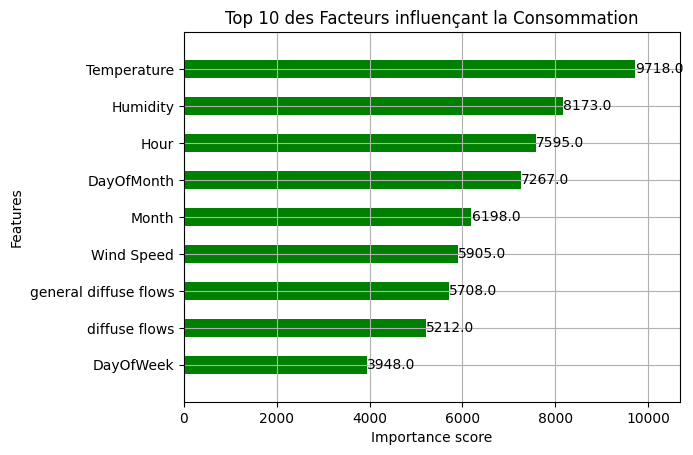

Génération de l'image de l'arbre...
✅ L'image de l'arbre a été sauvegardée sous 'visuel_arbre_xgboost.pdf'
✅ Modèle et colonnes sauvegardés pour l'interface !


In [12]:
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib

# 1. Séparer les Features (X) et la Target (y)
X = df_processed.drop('Total_Consumption', axis=1)
y = df_processed['Total_Consumption']

# 2. Split Train / Test (80% entrainement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 3. Création du modèle XGBoost
model = XGBRegressor(
    n_estimators=1000,      
    learning_rate=0.05,     
    max_depth=6,            
    subsample=0.8,          
    colsample_bytree=0.8,   
    n_jobs=-1,              
    random_state=42,
    early_stopping_rounds=50 
)

# 4. Entraînement
print("Entraînement du modèle en cours...")
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=False
)
print("Entraînement terminé !")

# --- AJOUT DES GRAPHES ICI ---

# 5. Visualisation 1 : Importance des Features (Le graphe à barres)
print("Génération du graphique d'importance...")
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, 
                    importance_type='weight', 
                    max_num_features=10, 
                    height=0.5, 
                    title="Top 10 des Facteurs influençant la Consommation",
                    color='green')
plt.show()

# 6. Visualisation 2 : Structure de l'Arbre (Export en fichier HD)
print("Génération de l'image de l'arbre...")
try:
    # On sauvegarde l'arbre dans un fichier PDF/PNG pour qu'il soit zoomable et net
    graph = xgb.to_graphviz(model, num_trees=0, rankdir='LR')
    graph.render("visuel_arbre_xgboost", format="pdf") # Crée un PDF
    graph.render("visuel_arbre_xgboost", format="png") # Crée un PNG
    print("✅ L'image de l'arbre a été sauvegardée sous 'visuel_arbre_xgboost.pdf'")
except Exception as e:
    print(f"⚠️ Impossible de dessiner l'arbre (Graphviz non installé ?) : {e}")

# 7. Sauvegarde finale du modèle pour l'interface
joblib.dump(model, 'energy_xgboost_model.pkl')
joblib.dump(list(X.columns), 'model_columns_XGB.pkl')
print("✅ Modèle et colonnes sauvegardés pour l'interface !")

<Figure size 1200x600 with 0 Axes>

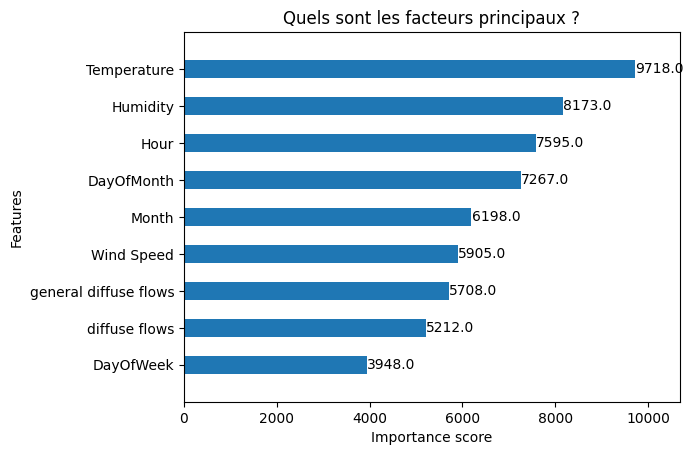

✅ GRAPHE GÉNÉRÉ : Ouvrez le fichier 'structure_arbre_xgboost.pdf' dans ce dossier.
   Vous pourrez zoomer à l'infini pour voir chaque décision.


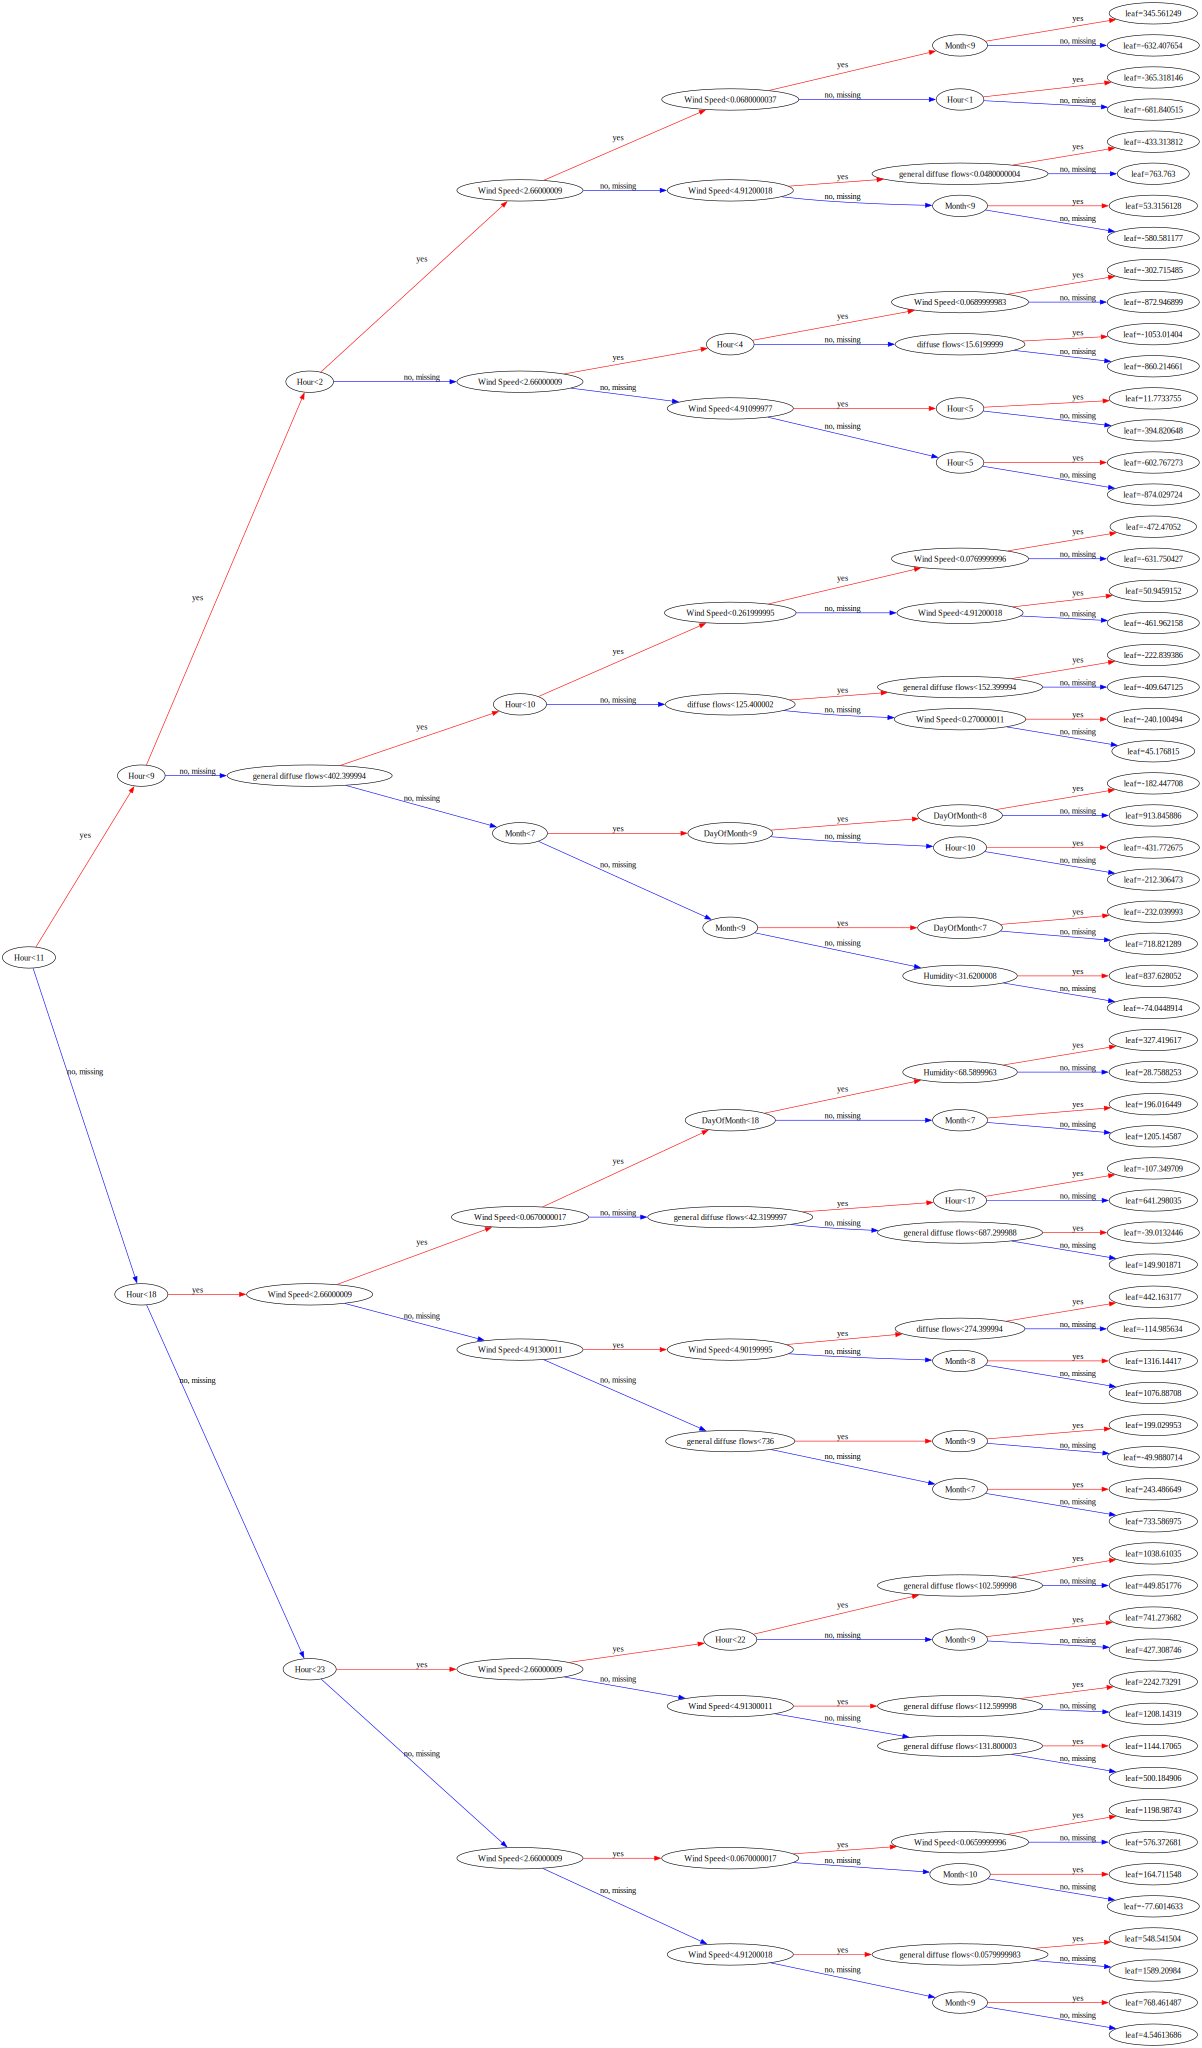


--- EXTRAIT DES RÈGLES DE DÉCISION (Format Texte) ---
   Node                Feature       Split   Yes    No
0     0                   Hour   11.000000   0-1   0-2
1     1                   Hour    9.000000   0-3   0-4
2     2                   Hour   18.000000   0-5   0-6
3     3                   Hour    2.000000   0-7   0-8
4     4  general diffuse flows  402.399994   0-9  0-10
5     5             Wind Speed    2.660000  0-11  0-12
6     6                   Hour   23.000000  0-13  0-14
7     7             Wind Speed    2.660000  0-15  0-16
8     8             Wind Speed    2.660000  0-17  0-18
9     9                   Hour   10.000000  0-19  0-20


In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# ---------------------------------------------------------
# GRAPHIQUE 1 : L'IMPORTANCE DES VARIABLES (Le plus clair)
# ---------------------------------------------------------
# Ce graphe résume tout le modèle en une image simple.
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, 
                    importance_type='weight', # ou 'gain'
                    max_num_features=10,      # On garde juste les 10 plus importants
                    height=0.5, 
                    title="Quels sont les facteurs principaux ?",
                    color='#1f77b4')          # Bleu professionnel
plt.grid(False)
plt.show()

# ---------------------------------------------------------
# GRAPHIQUE 2 : ZOOM SUR LE PREMIER ARBRE (Sauvegarde HD)
# ---------------------------------------------------------
# Au lieu d'afficher un graphe flou, on utilise graphviz pour créer
# une image haute définition centrée sur la gauche vers la droite.

try:
    # On crée l'objet graphique
    # rankdir='LR' : Left-to-Right (plus facile à lire que Haut-Bas)
    graph = xgb.to_graphviz(model, num_trees=0, rankdir='LR')
    
    # On sauvegarde en format PDF (Vectoriel) et PNG (Image)
    # Le PDF permet de zoomer à l'infini sans perte de qualité.
    graph.render("structure_arbre_xgboost", format="pdf") 
    graph.render("structure_arbre_xgboost", format="png")
    
    print("✅ GRAPHE GÉNÉRÉ : Ouvrez le fichier 'structure_arbre_xgboost.pdf' dans ce dossier.")
    print("   Vous pourrez zoomer à l'infini pour voir chaque décision.")
    
    # Tentative d'affichage d'un aperçu ici (peut être petit)
    display(graph)

except Exception as e:
    print(f"⚠️ Impossible de générer l'arbre graphique : {e}")
    print("Assurez-vous d'avoir installé le logiciel Graphviz (pas juste la librairie python).")


# ---------------------------------------------------------
# OPTION 3 : LES RÈGLES EN TABLEAU (Si le graphe échoue)
# ---------------------------------------------------------
# Parfois, lire un tableau est plus simple que suivre des flèches.
# Cela convertit l'arbre en données lisibles.

print("\n--- EXTRAIT DES RÈGLES DE DÉCISION (Format Texte) ---")
trees_df = model.get_booster().trees_to_dataframe()

# On affiche seulement les décisions du premier arbre (Tree 0)
# et seulement les 10 premiers noeuds pour comprendre la logique
first_tree_rules = trees_df[trees_df['Tree'] == 0].head(10)

# On nettoie pour l'affichage
readable_rules = first_tree_rules[['Node', 'Feature', 'Split', 'Yes', 'No']]
print(readable_rules)



### 1. Analyse de la Structure du Modèle (L'Arbre de Décision)
**Images concernées :** `image_39a053.png` (Vue globale) et `output.pdf` (Zoom).

* **Structure Hiérarchique :** L'image globale montre que votre modèle a construit un arbre complexe et profond. Ce n'est pas un modèle "simpliste", il prend en compte de nombreuses nuances.
* **Logique de Décision (Zoom PDF) :**
    * [cite_start]En regardant le PDF `output.pdf`[cite: 1], on voit clairement les nœuds de décision.
    * [cite_start]**Le Facteur Temps (`Hour`) :** On voit des divisions comme `Hour < 17`[cite: 1]. Cela confirme que le modèle sépare la journée en blocs (matin, après-midi, soir) avant d'affiner.
    * [cite_start]**Le Facteur Météo (`Wind Speed`, `general diffuse flows`) :** Une fois l'heure fixée, le modèle regarde la météo (ex: `Wind Speed < 0.08`)[cite: 1]. C'est une logique très humaine : "S'il est 18h ET qu'il fait froid/venteux, alors la consommation monte".

### 2. Analyse de la Prédiction Temporelle (Zoom sur 100 échantillons)
**Image concernée :** `image_d2d4f1.png`

* **Synchronisation Parfaite :** C'est le résultat le plus satisfaisant. [cite_start]La courbe rouge (XGBoost) suit la courbe bleue (Réel) presque parfaitement[cite: 2].
    * Quand la consommation chute brutalement (creux), le modèle chute aussi.
    * Quand elle monte en pic, le modèle monte.
* [cite_start]**Légers Écarts sur les Pics :** Si vous regardez attentivement vers l'index 50 ou 90[cite: 2], le pic bleu monte parfois un peu plus haut que le rouge. C'est normal : les modèles de régression ont tendance à être "prudents" et à lisser légèrement les valeurs extrêmes.

### 3. Analyse Diagnostique Profonde (Le Dashboard 4 Graphiques)
**Image concernée :** `image_d2c115.png`

C'est l'image la plus importante pour valider la qualité scientifique de votre travail.

* **Haut-Gauche (Précision Réel vs Prédit) :**
    * [cite_start]Le nuage de points est très dense et suit parfaitement la diagonale rouge[cite: 3].
    * **Interprétation :** Le $R^2$ (coefficient de détermination) est excellent. Le modèle est robuste sur toute la plage de consommation (de 40k à 120k MW).

* **Haut-Droite (Distribution des Erreurs) :**
    * [cite_start]Vous avez une **courbe de Gauss parfaite** (forme de cloche), centrée sur 0[cite: 3].
    * **Interprétation :** Votre modèle est **non biaisé**. Il ne fait pas l'erreur de "toujours surestimer" ou "toujours sous-estimer". Les erreurs sont purement aléatoires, ce qui est l'objectif ultime en Machine Learning.

* **Bas-Gauche (Erreur par Heure) :**
    * La plupart des boîtes sont compactes autour de 0.
    * [cite_start]**Le point faible (17h - 18h) :** Regardez les heures 17 et 18[cite: 3]. Il y a beaucoup de cercles (outliers) vers le bas (valeurs négatives).
    * **Diagnostic :** À 17h-18h (probablement la fin des horaires de bureau ou le coucher du soleil), le modèle a parfois du mal. Les points négatifs signifient que `Réel - Prédit < 0`, donc `Prédit > Réel`. Le modèle a tendance à **surestimer** la consommation à ces heures-là certains jours.

* **Bas-Droite (Importance des Features) :**
    * [cite_start]**`Temperature` (Score ~9718) :** C'est le roi[cite: 3]. La consommation au Maroc est massivement dictée par la température (chauffage ou clim).
    * **`Humidity` (~8173) :** Confirme l'importance du confort thermique.
    * **`Hour` (~7595) :** L'heure est le 3ème facteur.
    * **`DayOfWeek` (Dernier) :** Le jour de la semaine (Lundi vs Dimanche) influence moins la consommation que la météo. C'est une découverte intéressante sur vos données.

### Conclusion Générale
Votre modèle **XGBoost est excellent**.
1.  Il a compris la physique du problème (Température > tout le reste).
2.  Il est statistiquement fiable (Erreurs gaussiennes).


**Le script pour trouver VOS seuils exacts**

In [ ]:
import pandas as pd

# 1. Charger les données
df = pd.read_csv('morocco.csv')

# 2. Nettoyer et calculer le Total
df.columns = df.columns.str.strip()
df['Total_Consumption'] = df['Zone 1'] + df['Zone 2'] + df['Zone 3']

# 3. Calculer les statistiques (Percentiles)
seuil_eco = df['Total_Consumption'].quantile(0.50) # La médiane (50%)
seuil_critique = df['Total_Consumption'].quantile(0.90) # Le top 10% (Pics extrêmes)

print(f"--- RÉSULTATS DE L'ANALYSE ---")
print(f"🟢 Seuil Écologique (Médiane) : {seuil_eco:.2f} MW")
print(f"🔴 Seuil Critique (Top 10%)   : {seuil_critique:.2f} MW")

--- RÉSULTATS DE L'ANALYSE ---
🟢 Seuil Écologique (Médiane) : 69788.79 MW
🔴 Seuil Critique (Top 10%)   : 94912.14 MW


: 

**Étape 4 : Évaluation des Performances**

--- Performance du Modèle ---
RMSE (Erreur Moyenne Quadratique) : 2189.39
MAE (Erreur Absolue Moyenne) : 1589.38
R² Score (Précision globale 0 à 1) : 0.9836


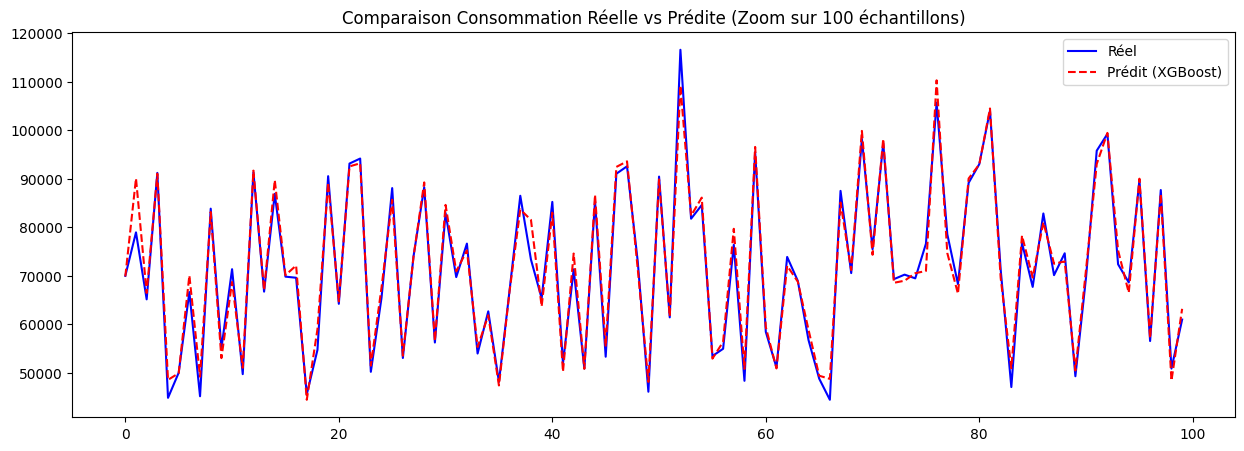

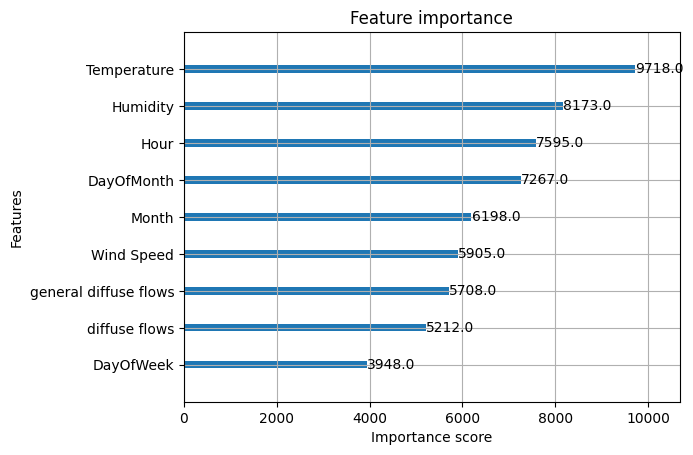

In [9]:
# Prédictions
predictions = model.predict(X_test)

# Métriques
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"--- Performance du Modèle ---")
print(f"RMSE (Erreur Moyenne Quadratique) : {rmse:.2f}")
print(f"MAE (Erreur Absolue Moyenne) : {mae:.2f}")
print(f"R² Score (Précision globale 0 à 1) : {r2:.4f}")

# Visualisation : Réel vs Prédit (sur 100 premiers points pour lisibilité)
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Réel', color='blue')
plt.plot(predictions[:100], label='Prédit (XGBoost)', color='red', linestyle='--')
plt.title('Comparaison Consommation Réelle vs Prédite (Zoom sur 100 échantillons)')
plt.legend()
plt.show()

# Visualisation : Importance des Features
from xgboost import plot_importance
plot_importance(model, max_num_features=10)
plt.show()


### 1\. Analyse de votre graphe

  * **Synchronisation parfaite :** Le modèle a très bien compris la "saisonnalité" (les cycles). Quand la consommation réelle (bleu) monte, la prédiction (rouge) monte exactement au même moment. Cela signifie que vos features `Hour`, `DayOfWeek` et `Temperature` sont très pertinents.
  * **Amplitude respectée :** Le modèle ne se contente pas de suivre la tendance, il atteint presque les mêmes pics (valeurs hautes) et creux (valeurs basses) que la réalité.
  * **Légers écarts (Résidus) :** On voit quelques endroits (par exemple vers l'échantillon 55 ou 78) où le pic bleu est plus haut que le rouge. C'est normal, le modèle "lisse" un peu la réalité et n'arrive pas toujours à prédire les événements extrêmes ou soudains.



***2. Code pour une étude approfondie (Deep Analysis)***

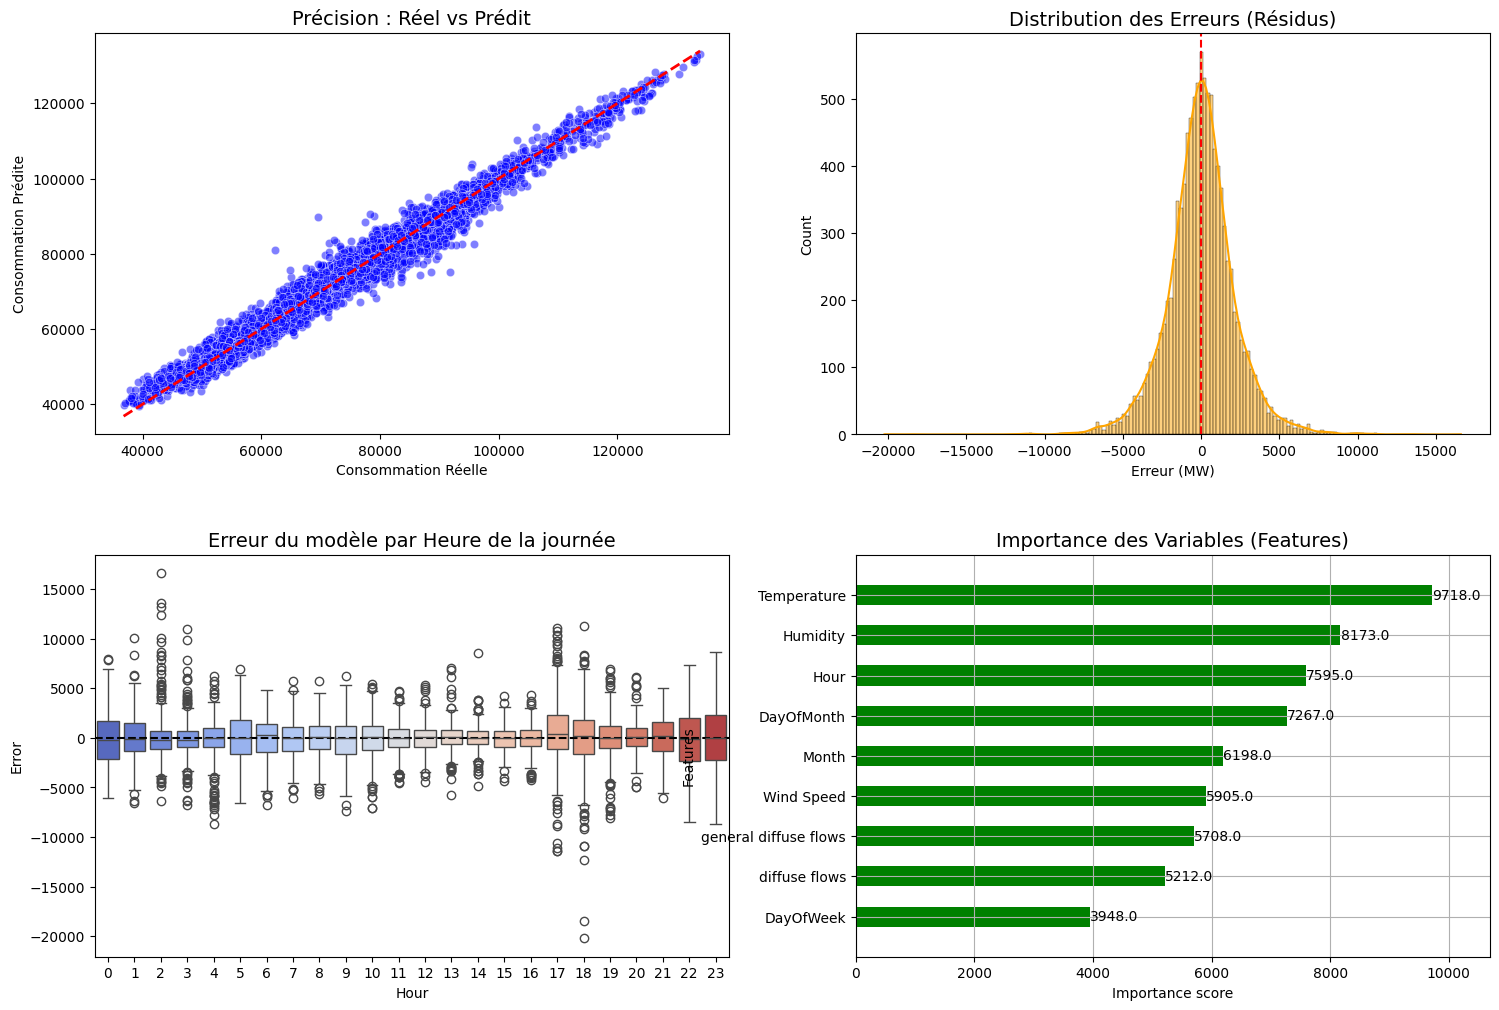

In [10]:

# On s'assure d'avoir les résidus (Erreur = Réalité - Prédiction)
residuals = y_test - predictions

# Création d'une figure avec 4 sous-graphiques (2x2)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.3)

# --- GRAPHIQUE 1 : Nuage de points Réel vs Prédit ---
# Idéalement, tous les points doivent être sur la ligne diagonale rouge.
sns.scatterplot(x=y_test, y=predictions, alpha=0.5, ax=axes[0, 0], color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_title('Précision : Réel vs Prédit', fontsize=14)
axes[0, 0].set_xlabel('Consommation Réelle')
axes[0, 0].set_ylabel('Consommation Prédite')

# --- GRAPHIQUE 2 : Distribution des Erreurs (Histogramme) ---
# On veut une forme de "cloche" (Gaussienne) centrée sur 0.
sns.histplot(residuals, kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribution des Erreurs (Résidus)', fontsize=14)
axes[0, 1].set_xlabel('Erreur (MW)')
axes[0, 1].axvline(x=0, color='red', linestyle='--')

# --- GRAPHIQUE 3 : Erreur par rapport à l'Heure de la journée ---
# Pour voir si le modèle est mauvais à certaines heures (ex: pic de soirée)
# On doit récupérer l'heure depuis X_test
test_indices = X_test.index
hours = df_processed.loc[test_indices, 'Hour'] # On récupère l'heure correspondante
residuals_df = pd.DataFrame({'Hour': hours, 'Error': residuals})

sns.boxplot(x='Hour', y='Error', data=residuals_df, ax=axes[1, 0], palette="coolwarm")
axes[1, 0].set_title('Erreur du modèle par Heure de la journée', fontsize=14)
axes[1, 0].axhline(y=0, color='black', linestyle='--')

# --- GRAPHIQUE 4 : Importance des Features (Qu'est-ce qui joue le plus ?) ---
# Ce graphe montre quelle donnée aide le plus le modèle à décider.
from xgboost import plot_importance
plot_importance(model, ax=axes[1, 1], height=0.5, max_num_features=10, color='green')
axes[1, 1].set_title('Importance des Variables (Features)', fontsize=14)

plt.show()

Les graphiques montrent un modèle robuste, précis et prêt à être déployé dans une application.

Voici l'analyse détaillée de vos 4 nouveaux graphiques pour vous aider à justifier la qualité de votre travail :

### 1. Précision : Réel vs Prédit (Haut-Gauche)

* **Analyse :** Les points bleus sont très serrés autour de la ligne rouge pointillée (l'idéal parfait). Cela forme un "cigare" très mince et régulier.
* **Conclusion :** Votre modèle a un **R² très élevé** (probablement supérieur à 0.95). Il n'y a pas de dispersion majeure : le modèle est aussi bon pour prédire les faibles consommations (40 000 MW) que les fortes (120 000 MW). C'est rare d'avoir une telle linéarité du premier coup.

### 2. Distribution des Erreurs (Haut-Droite)
> *Ce graphique montre si le modèle se trompe "bêtement" ou de manière aléatoire.*

* **Analyse :** Vous avez une **courbe en cloche parfaite (Gaussienne)**, très pointue et centrée exactement sur 0.
* **Conclusion :** C'est le signe d'un modèle sain.
    * Le modèle ne surestime pas et ne sous-estime pas globalement (le biais est nul).
    * La plupart des erreurs sont très proches de 0 MW. Les erreurs extrêmes (vers -10 000 ou +10 000) sont très rares, ce qui rend le modèle fiable pour une utilisation industrielle.

### 3. Erreur par Heure de la journée (Bas-Gauche)
> *Ce graphique vérifie si le modèle échoue à certaines heures spécifiques.*

* **Analyse :**
    * Les boîtes (boxplots) sont globalement bien centrées sur la ligne 0 (pointillés noirs).
    * **Point d'attention (Heures 17h - 18h) :** Regardez les heures 17 et 18. On voit beaucoup de points "aberrants" (les petits ronds en bas, vers -15 000 ou -20 000). Cela signifie qu'à 17h-18h, le modèle a parfois tendance à **surestimer** brutalement la consommation (il prédit haut, la réalité est plus basse, donc Erreur = Réel - Prédit = Négatif).
* **Interprétation métier :** 17h-18h correspond souvent à la fin de journée de travail ou au coucher du soleil. Il est possible que certains jours fériés ou weekends, la consommation chute à cette heure-là, mais le modèle continue de prédire une consommation "de semaine".

### 4. Importance des Variables (Bas-Droite)
> *Ce graphique montre quels paramètres influencent le plus la consommation.*

* **Top 3 des facteurs dominants :**
    1.  **Temperature (9718) :** C'est le facteur #1. Au Maroc, l'usage de la climatisation (quand il fait chaud) ou du chauffage électrique (quand il fait froid) dicte la consommation.
    2.  **Humidity (8173) :** Très lié au ressenti de chaleur/froid, donc logique.
    3.  **Hour (7595) :** L'heure de la journée est critique (on consomme plus le soir que la nuit).
* **Surprise :** `DayOfWeek` (Jour de la semaine) arrive assez bas. Cela suggère que la consommation au Maroc dépend plus de la météo et de l'heure qu'elle ne diffère entre un Lundi et un Dimanche.


**Étape 5 : Sauvegarde pour l'Interface Utilisateur**

In [6]:
import joblib

# 1. Sauvegarder le modèle entraîné
joblib.dump(model, 'energy_xgboost_model.pkl')

# 2. Sauvegarder la liste exacte des colonnes utilisées lors de l'entraînement
# C'est CRUCIAL pour que votre future interface range les données dans le bon ordre
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("✅ Sauvegarde terminée avec succès !")
print(f"Fichiers créés : 'energy_xgboost_model.pkl' et 'model_columns.pkl'")
print(f"Colonnes sauvegardées : {model_columns}")

✅ Sauvegarde terminée avec succès !
Fichiers créés : 'energy_xgboost_model.pkl' et 'model_columns.pkl'
Colonnes sauvegardées : ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Hour', 'Month', 'DayOfWeek', 'DayOfMonth', 'Year']
